In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from pyqtorch.core.circuit import QuantumCircuit
from pyqtorch.ansatz import AlternateLayerAnsatz
from pyqtorch.embedding import SingleLayerEncoding
from pyqtorch.core.operation import Z, RX
import math

In [3]:
def target_function(x, function=None, factor=1, degree=1):
    """Defining a function that takes in x, function, factor, and degree.
    It then returns a result.  If function is None, it will return a
    trigonometric function. If function is not None, it will return a custom
    function.

    Args:
        x (_type_): _description_ function (_type_, optional): _description_.
        Defaults to None. factor (int, optional): _description_. Defaults to 1.
        degree (int, optional): _description_. Defaults to 3.

    Returns:
        _type_: _description_
    """
    result = 0
    if function == None:
        # some trigo function
        for i in range(degree):
            result += torch.cos(i * x) + torch.sin(i * x)
        result *= factor
    else:
        # custom function
        result = factor * function(x)

    return result

In [4]:
# Creating a dictionary with keys that are strings and values that are functions.
FUNCTIONS = {
    "0": None,
    "1": lambda a: 2 * a,
    "2": lambda a: a**2,
    "3": lambda a: a**3,
    "4": math.cos,
    "5": math.sin,
    "6": math.tan,
}
FUNCTION = "1"
function = FUNCTIONS[FUNCTION]
factor = 1.0  # 0.015
degree = 5

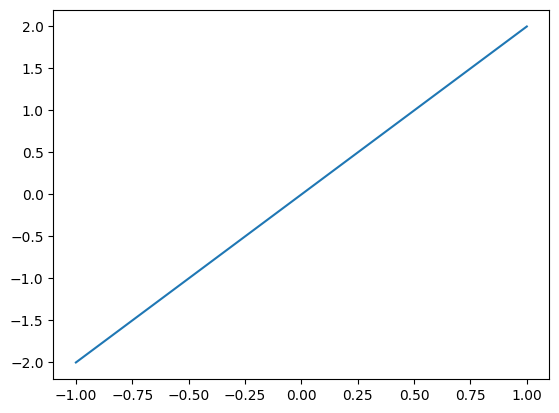

In [5]:
# Plotting the target function.
x = torch.tensor(np.linspace(-1, 1, 100))  # has to be -1, 1 interval for Cheb.
target_y = target_function(x, function=function, factor=factor, degree=degree)
plt.plot(x.numpy(), target_y.numpy())

In [6]:
# Different feature maps and rotations bloacks.

from pyqtorch.core.operation import batchedRY
from pyqtorch.core.circuit import QuantumCircuit


class SingleLayerRyEncoding(QuantumCircuit):
    """
    Single layer quantum circuit for encoding a single layer quantum circuit.
    """

    def __init__(self, n_qubits):
        super().__init__(n_qubits)

    def forward(self, state, x):
        for i in range(self.n_qubits):
            state = batchedRY(x, state, [i], self.n_qubits)
        return state


class ChebychevTowerEncoding(QuantumCircuit):
    """
    Quantum circuit for the Chebychev Tower encoding.
    """

    def __init__(self, n_qubits):
        super().__init__(n_qubits)

    def forward(self, state, x):
        for i in range(self.n_qubits):
            state = batchedRY(
                torch.tensor(i, dtype=torch.float64) * torch.arccos(x),
                state,
                [i],
                self.n_qubits,
            )
        return state


class ChebychevSparseEncoding(QuantumCircuit):
    """
    Quantum circuit for the Chebychev Sparse encoding.
    """

    def __init__(self, n_qubits):
        super().__init__(n_qubits)

    def forward(self, state, x):
        for i in range(self.n_qubits):
            state = batchedRY(
                torch.arccos(x),
                state,
                [i],
                self.n_qubits,
            )
        return state


class SingleQubitRotation(QuantumCircuit):
    """
    Quantum circuit for the single qubit rotation.
    """

    def __init__(self, n_qubits, arbitrary=False):
        super().__init__(n_qubits)
        self.theta = nn.Parameter(torch.empty((self.n_qubits, 3)))
        self.reset_parameters()
        self.arbitrary = arbitrary

    def reset_parameters(self):
        init.uniform_(self.theta, -2 * np.pi, 2 * np.pi)

    def forward(self, state):
        for i, t in enumerate(self.theta):
            state = U(t[0], t[1], t[2], state, [i], self.n_qubits)
        return state

In [7]:
class Model1(QuantumCircuit):
    """Model with no feature map function."""

    def __init__(self, n_qubits, n_layers):
        super().__init__(n_qubits)
        # ansatzes
        if n_qubits == 1:
            self.ansatz1 = SingleQubitRotation(n_qubits, n_layers)
        else:
            self.ansatz1 = AlternateLayerAnsatz(n_qubits, n_layers)
        self.embedding = SingleLayerRyEncoding(n_qubits)
        # parameters
        self.param_coef = nn.Parameter(torch.tensor(1, dtype=torch.float64))
        self.param_offset = nn.Parameter(torch.tensor(1, dtype=torch.float64))

    def forward(self, x):
        batch_size = len(x)
        state = self.init_state(batch_size)

        state = self.ansatz1(state)
        state = self.embedding(state, x)

        # expectation value
        new_state = self.param_coef * Z(state, [0], self.n_qubits)

        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))

        return torch.real(
            torch.sum(torch.conj(state) * new_state, axis=0) + self.param_offset
        )


class Model2(QuantumCircuit):
    """Model with feature map function."""

    def __init__(self, n_qubits, n_layers):
        super().__init__(n_qubits)
        # ansatzes
        self.ansatz1 = SingleQubitRotation(n_qubits, arbitrary=False)
        self.embedding = ChebychevSparseEncoding(n_qubits)
        # parameters
        self.param_coef = nn.Parameter(torch.tensor(1, dtype=torch.float64))
        self.param_offset = nn.Parameter(
            torch.tensor(1e-5, dtype=torch.float64)
        )

    def forward(self, x):
        batch_size = len(x)

        state = self.init_state(batch_size)
        state = self.ansatz1(state)
        state = self.embedding(state, x)

        # expectation value
        new_state = self.param_coef * Z(state, [0], self.n_qubits)

        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))

        return torch.real(
            torch.sum(torch.conj(state) * new_state, axis=0) + self.param_offset
        )

In [23]:
n_qubits = 1
n_layers = 1
model = Model2(n_qubits, n_layers)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10_000

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = F.mse_loss(target_y, y_pred)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss {loss}")

Epoch 1 | Loss 3.0380136261730155
Epoch 2 | Loss 3.03549752727658
Epoch 3 | Loss 3.032981281903416
Epoch 4 | Loss 3.0304651061291925
Epoch 5 | Loss 3.027948956553952
Epoch 6 | Loss 3.0254325922380723
Epoch 7 | Loss 3.0229160688658605
Epoch 8 | Loss 3.0203997334845987
Epoch 9 | Loss 3.017883455463077
Epoch 10 | Loss 3.0153672462100864
Epoch 11 | Loss 3.0128508006949306
Epoch 12 | Loss 3.0103346595495184
Epoch 13 | Loss 3.0078181982288696
Epoch 14 | Loss 3.0053022244614938
Epoch 15 | Loss 3.002785974472813
Epoch 16 | Loss 3.000269883762989
Epoch 17 | Loss 2.997753909407931
Epoch 18 | Loss 2.995237888947992
Epoch 19 | Loss 2.992721968706836
Epoch 20 | Loss 2.990206010817329
Epoch 21 | Loss 2.9876902306696196
Epoch 22 | Loss 2.985174676957121
Epoch 23 | Loss 2.98265913694598
Epoch 24 | Loss 2.980143652356909
Epoch 25 | Loss 2.977627928430729
Epoch 26 | Loss 2.9751126673333976
Epoch 27 | Loss 2.9725974342070534
Epoch 28 | Loss 2.970082455886502
Epoch 29 | Loss 2.9675672926614483
Epoch 30 | 

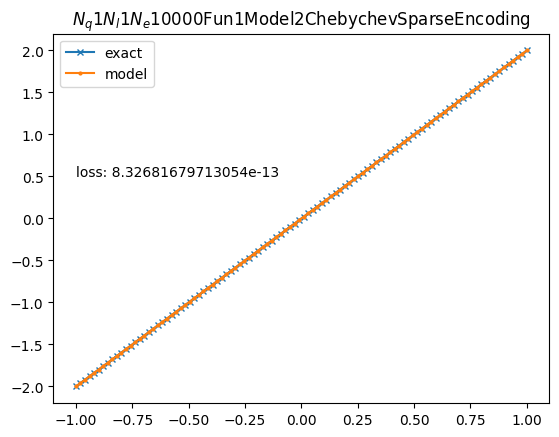

In [25]:
with torch.no_grad():
    y = model(x)

# Plotting the exact function and the model function.
plt.plot(x.numpy(), target_y.numpy(), label="exact", marker="x", markersize=4)
plt.plot(x.numpy(), y.numpy(), label="model", marker="o", markersize=2)
plt.legend()
plt.title(
    f"$N_q{n_qubits}N_l{n_layers}N_e{epochs}$Fun{FUNCTION}{model.__class__.__name__}"
    f"{model.embedding.__class__.__name__}"
)
plt.text(-1, 0.5, f"loss: {loss.detach().numpy()}")
# plot text in the plot
plt.show()

In [26]:
# Print parameters.
for ps in model.parameters():
    print(ps)

Parameter containing:
tensor(2.0006, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(-2.9673e-06, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-1.1049,  0.0250, -4.7123]], requires_grad=True)
